In [215]:
#! pip install pylatexenc
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.synthesis import SuzukiTrotter

# Primitives
from qiskit.primitives import StatevectorSampler
# Check for BackendSamplerV2 availability
try:
    from qiskit.primitives import BackendSamplerV2
except ImportError:
    from qiskit.primitives import BackendSampler as BackendSamplerV2

# For Noisy Simulation
from qiskit_ibm_runtime.fake_provider import FakeManilaV2 
from qiskit_aer import AerSimulator

# For Real Device
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as RuntimeSamplerV2

from sympy.physics.quantum.cg import CG
import os


In [216]:

# --- Hamiltonian Construction ---

def parse_ckpot(filepath):
    spe = {}
    tbme = {}
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    reading_spe = False
    reading_tbme = False
    
    for line in lines:
        parts = line.split()
        if not parts or parts[0].startswith('!'):
            continue
        try:
            nums = [float(x) for x in parts]
        except ValueError:
            continue
            
        if len(nums) == 2 and int(nums[0]) == 4 and int(nums[1]) == 0:
            reading_spe = True
            continue
        if len(nums) == 3 and int(nums[0]) == 34:
            reading_spe = False
            reading_tbme = True
            continue
            
        if reading_spe:
            if len(nums) >= 3:
                idx = int(nums[0])
                energy = nums[2]
                if idx == 3: spe['p1/2'] = energy
                if idx == 4: spe['p3/2'] = energy
                
        if reading_tbme:
            if len(nums) >= 6:
                i, j, k, l = int(nums[0]), int(nums[1]), int(nums[2]), int(nums[3])
                J = int(nums[4])
                val = nums[5]
                tbme[(i,j,k,l,J)] = val
                
    return spe, tbme

# Load interaction
ckpot_path = '../interaction_file/ckpot.snt'
if not os.path.exists(ckpot_path):
    print(f"Warning: {ckpot_path} not found. Using dummy values.")
    spe = {'p1/2': 0.0, 'p3/2': 2.0}
    tbme_data = {}
else:
    spe, tbme_data = parse_ckpot(ckpot_path)

# CG Coefficients
def get_cg(j, m1, m2, J, M):
    return float(CG(j, m1, j, m2, J, M).doit())

c_0_J0 = get_cg(1/2, 1/2, -1/2, 0, 0)
c_1_J0 = get_cg(3/2, 1/2, -1/2, 0, 0)
c_1_J2 = get_cg(3/2, 1/2, -1/2, 2, 0)
c_2_J0 = get_cg(3/2, 3/2, -3/2, 0, 0)
c_2_J2 = get_cg(3/2, 3/2, -3/2, 2, 0)

basis = {
    0: {'shell': 3, 'coeffs': {0: c_0_J0}},
    1: {'shell': 4, 'coeffs': {0: c_1_J0, 2: c_1_J2}},
    2: {'shell': 4, 'coeffs': {0: c_2_J0, 2: c_2_J2}}
}

def get_tbme_val(i, j, k, l, J):
    key = (i, j, k, l, J)
    if key in tbme_data: return tbme_data[key]
    key = (k, l, i, j, J)
    if key in tbme_data: return tbme_data[key]
    return 0.0

V_matrix = np.zeros((3, 3))
for a in range(3):
    for b in range(3):
        shell_a = basis[a]['shell']
        shell_b = basis[b]['shell']
        val = 0.0
        common_Js = set(basis[a]['coeffs'].keys()) & set(basis[b]['coeffs'].keys())
        for J in common_Js:
            c_a = basis[a]['coeffs'][J]
            c_b = basis[b]['coeffs'][J]
            mat_el = get_tbme_val(shell_a, shell_a, shell_b, shell_b, J)
            val += c_a * c_b * mat_el
        V_matrix[a, b] = val

E_pair = np.zeros(3)
epsilon = {3: spe['p1/2'], 4: spe['p3/2']}
for i in range(3):
    shell = basis[i]['shell']
    E_pair[i] = 2 * epsilon[shell] + V_matrix[i, i]

# Construct H_op
ham_ops = []
num_qubits = 3

for i in range(num_qubits):
    label = ['I'] * num_qubits
    label[i] = 'Z'
    z_str = "".join(reversed(label))
    ham_ops.append(("I"*num_qubits, E_pair[i] / 2))
    ham_ops.append((z_str, -E_pair[i] / 2))

for i in range(num_qubits):
    for j in range(i + 1, num_qubits):
        coupling = V_matrix[i, j]
        
        label_x = ['I'] * num_qubits
        label_x[i] = 'X'
        label_x[j] = 'X'
        x_str = "".join(reversed(label_x))
        ham_ops.append((x_str, coupling / 2))
        
        label_y = ['I'] * num_qubits
        label_y[i] = 'Y'
        label_y[j] = 'Y'
        y_str = "".join(reversed(label_y))
        ham_ops.append((y_str, coupling / 2))

H_op = SparsePauliOp.from_list(ham_ops).simplify()
print("Hamiltonian Operator:")
print(H_op)

# Exact Solution
full_matrix = H_op.to_matrix()
indices = [1, 2, 4]
sub_mat = np.zeros((3, 3), dtype=complex)
for r, i in enumerate(indices):
    for c, j in enumerate(indices):
        sub_mat[r, c] = full_matrix[i, j]
exact_evals, _ = np.linalg.eigh(sub_mat)
print(f"Exact Eigenvalues (Physical Subspace): {exact_evals}")


Hamiltonian Operator:
SparsePauliOp(['III', 'IIZ', 'IZI', 'ZII', 'IXX', 'IYY', 'XIX', 'YIY', 'XXI', 'YYI'],
              coeffs=[ 3.927775  +0.j, -2.48      +0.j, -0.7238875 +0.j, -0.7238875 +0.j,
  0.89318193+0.j,  0.89318193+0.j, -0.89318193+0.j, -0.89318193+0.j,
  0.4270625 +0.j,  0.4270625 +0.j])
Exact Eigenvalues (Physical Subspace): [-0.56210369  2.3019      6.11575369]


Ansatz Circuit:


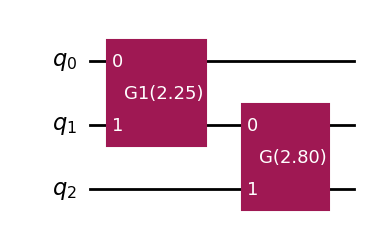

In [217]:

# --- Ansatz Circuit ---

def G1_gate(theta):
    theta = theta * 2
    circ = QuantumCircuit(2)
    circ.x(0)
    circ.ry(theta, 1)
    circ.cx(1, 0)
    circ.name = f'G1({theta:.2f})'
    return circ.to_gate()

def G_gate(theta):
    theta = theta * 2
    circ = QuantumCircuit(2)
    circ.cry(theta, 0, 1)
    circ.cx(1, 0)
    circ.name = f'G({theta:.2f})'
    return circ.to_gate()

def ansatz(params):
    qc = QuantumCircuit(3)
    qc.append(G1_gate(params[0]), [0, 1])
    qc.append(G_gate(params[1]), [1, 2])
    return qc

init_params = np.pi / 4 * np.ones(2)
# Initial Parameters
init_params = np.random.uniform(0, np.pi, size=2)
qc_ansatz = ansatz(init_params)
print("Ansatz Circuit:")
qc_ansatz.draw('mpl')


In [218]:
# --- Quantum Krylov Functions ---

def count_gates(qc, name="Circuit"):
    """Helper to print gate counts for a circuit."""
    ops = qc.count_ops()
    depth = qc.depth()
    print(f"[{name}] Depth: {depth}, Gates: {ops}")
    return ops

def make_U(i, delta_t, trotter_steps, hamiltonian_op, target_qubits, Trotter_order=2):
    Ntar = len(target_qubits) 
    time = i * delta_t 
    circuit_U = QuantumCircuit(Ntar)
    expiHt = PauliEvolutionGate(hamiltonian_op, time, synthesis=SuzukiTrotter(order=Trotter_order,reps=trotter_steps))
    circuit_U.append(expiHt, range(Ntar))
    qc_U = circuit_U.decompose().decompose()
    return qc_U

def make_cU(Uprep, Ui, Ntar, only_Uprep=False):
    circuit_cUi = QuantumCircuit(Ntar)
    circuit_cUi.append(Uprep, range(Ntar))
    if not only_Uprep:
        circuit_cUi.append(Ui, range(Ntar))
    circuit_cUi = circuit_cUi.decompose(reps=1)
    return circuit_cUi.to_gate().control(1)

def get_idx_ancilla_in_string(n_qubit, ancilla, Qiskit_ordering=True):
    idx_ancilla = None
    if ancilla != None:
        if Qiskit_ordering:
            idx_ancilla = n_qubit-1 - ancilla
        else:
            idx_ancilla = ancilla
    return idx_ancilla

def make_overlap_qc_1c(Ntar, gate_cprep, gate_Uij, ancilla_qubits, target_qubits, do_measurement=True):
    qc_re = QuantumCircuit(1+Ntar, 1) # Overlap, Re part
    qc_re.h(0) # X basis
    qc_re.append(gate_cprep, ancilla_qubits + target_qubits)
    qc_re.append(gate_Uij, target_qubits)
    qc_re.x(0)
    qc_re.append(gate_cprep, ancilla_qubits + target_qubits)
    qc_re.x(0)
    qc_re.h(0) 
    if do_measurement:
        qc_re.measure(0,0)

    # Overlap, Im part 
    qc_im = QuantumCircuit(1+Ntar,1)
    qc_im.h(0)
    qc_im.append(gate_cprep, ancilla_qubits + target_qubits)
    qc_im.append(gate_Uij, target_qubits)
    qc_im.x(0)
    qc_im.append(gate_cprep, ancilla_qubits + target_qubits)
    qc_im.x(0)
    # Y basis
    qc_im.sdg(0)
    qc_im.h(0)
    if do_measurement:
        qc_im.measure(0,0)

    return qc_re, qc_im

def measure_overlap_1c(num_shot, Ntar, gate_cprep, gate_Uij, ancilla_qubits, target_qubits, sampler, using_statevector, backend_for_transpile=None):
    # If using Statevector, no measurement needed in circuit
    do_meas = not using_statevector
    qc_re, qc_im = make_overlap_qc_1c(Ntar, gate_cprep, gate_Uij, ancilla_qubits, target_qubits, do_meas)
    
    # Transpile first if needed (even for statevector if we want actual gate counts, but usually for SV we don't care as much)
    # However, if backend provided, we check counts post-transpile
    if backend_for_transpile is not None:
         qc_re = transpile(qc_re, backend_for_transpile)
         qc_im = transpile(qc_im, backend_for_transpile)
         # Print gate counts for first overlap calculation to avoid spam
         # Using a global or external flag is better, but here just check if it's new
         pass 

    if using_statevector:
        results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in [qc_re, qc_im]]
        prob_Re = results[0]
        prob_Im = results[1] 
    else:
        # Run with Sampler V2
        pub_re = (qc_re,)
        pub_im = (qc_im,)
        job = sampler.run([pub_re, pub_im], shots=num_shot)
        result = job.result() 
        
        def get_counts_safe(pub_res):
            if hasattr(pub_res.data, 'meas'): 
                return pub_res.data.meas.get_counts()
            elif hasattr(pub_res.data, 'c'): 
                return pub_res.data.c.get_counts()
            else:
                try: return pub_res.data.c.get_counts()
                except: return pub_res.data.meas.get_counts()

        counts_re = get_counts_safe(result[0])
        counts_im = get_counts_safe(result[1])
        
        # Convert counts to probabilities
        total_re = sum(counts_re.values())
        total_im = sum(counts_im.values())
        prob_Re = {k: v/total_re for k,v in counts_re.items()}
        prob_Im = {k: v/total_im for k,v in counts_im.items()}

    total_Re = np.sum(list(prob_Re.values()))
    total_Im = np.sum(list(prob_Im.values()))
    if total_Re == 0 or total_Im == 0:
        return 0.0 + 0.0j

    n_qubit_Re = len(list(prob_Re.keys())[0])
    n_qubit_Im = len(list(prob_Im.keys())[0])
    anc = ancilla_qubits[0] if ancilla_qubits else 0
    idx_ancilla_Re = get_idx_ancilla_in_string(n_qubit_Re, anc, Qiskit_ordering=True)
    idx_ancilla_Im = get_idx_ancilla_in_string(n_qubit_Im, anc, Qiskit_ordering=True)

    p0 = np.sum([ count for bitstr, count in prob_Re.items() if bitstr[idx_ancilla_Re] == '0' ]) 
    p1 = np.sum([ count for bitstr, count in prob_Re.items() if bitstr[idx_ancilla_Re] == '1' ]) 
    ReN = p0 - p1 

    p0 = np.sum([ count for bitstr, count in prob_Im.items() if bitstr[idx_ancilla_Im] == '0' ]) 
    p1 = np.sum([ count for bitstr, count in prob_Im.items() if bitstr[idx_ancilla_Im] == '1' ]) 
    ImN = p0 - p1

    if abs(ImN) < 1e-5: ImN = 0.0

    N_ij = ReN - 1j * ImN
    return N_ij, qc_re # Return QC for gate counting

def compute_N_matrix_incremental(prev_Nmat, it, delta_t, trotter_steps, Ntar, params, hamiltonian_op, num_shot, sampler, ancilla_qubits=[0], target_qubits=[1,2,3], using_statevector=True, backend_for_transpile=None):
    """Return expanded N-matrix for Krylov dimension `it`.

    - Diagonal elements are fixed to 1.0.
    - If `prev_Nmat` is None, creates a new matrix and computes all off-diagonal elements when it>1.
    - Otherwise expands `prev_Nmat` by one row/column and computes N[it-1, j] for j < it.
    """
    # Prepare Uprep and utilities
    Uprep = ansatz(params)
    gate_cprep = make_cU(Uprep, None, Ntar, only_Uprep=True)
    qc_cache = {}

    def get_qc_U(k):
        if k not in qc_cache:
            qc_u = make_U(k, delta_t, trotter_steps, hamiltonian_op, range(Ntar))
            qc_cache[k] = qc_u
        return qc_cache[k]

    # If no previous matrix provided, start from scratch with zeros
    if prev_Nmat is None:
        Nmat = np.zeros((it, it), dtype=complex)
        # Set diagonals to 1.0
        for idx in range(it):
            Nmat[idx, idx] = 1.0
        # If it==1 nothing else to compute
        if it == 1:
            return Nmat
        # compute all off-diagonals for full initialization
        for ii in range(it):
            for jj in range(ii):
                qc_Uij = get_qc_U(ii - jj)
                ret = measure_overlap_1c(num_shot, Ntar, gate_cprep, qc_Uij, ancilla_qubits, target_qubits, sampler, using_statevector, backend_for_transpile)
                if isinstance(ret, tuple):
                    Nij, qc_used = ret
                else:
                    Nij = ret
                    qc_used = None
                Nmat[ii, jj] = Nij
                Nmat[jj, ii] = np.conj(Nij)
                # log sample gate-count for the first off-diagonal
                if ii == 1 and jj == 0 and qc_used is not None:
                    print(f"  [Gate Count Sample] Overlap Circuit (N_10):")
                    count_gates(qc_used, "Re(N_10)")
        return Nmat

    # prev_Nmat exists: expand by one row/column
    old_n = prev_Nmat.shape[0]
    if it != old_n + 1:
        # If user requests arbitrary it smaller/larger, recompute from scratch conservatively
        Nmat = np.zeros((it, it), dtype=complex)
        for idx in range(it):
            Nmat[idx, idx] = 1.0
        # compute off-diagonals for the new last row/col
        new_idx = it - 1
        for j in range(new_idx):
            qc_Uij = get_qc_U(new_idx - j)
            ret = measure_overlap_1c(num_shot, Ntar, gate_cprep, qc_Uij, ancilla_qubits, target_qubits, sampler, using_statevector, backend_for_transpile)
            if isinstance(ret, tuple):
                Nij, qc_used = ret
            else:
                Nij = ret
                qc_used = None
            Nmat[new_idx, j] = Nij
            Nmat[j, new_idx] = np.conj(Nij)
        return Nmat

    # Normal incremental expansion by one
    Nmat = np.zeros((it, it), dtype=complex)
    Nmat[:old_n, :old_n] = prev_Nmat
    # set diagonal for new index
    new_idx = it - 1
    Nmat[new_idx, new_idx] = 1.0

    # compute off-diagonals between new row/col and previous rows
    for j in range(new_idx):
        qc_Uij = get_qc_U(new_idx - j)
        ret = measure_overlap_1c(num_shot, Ntar, gate_cprep, qc_Uij, ancilla_qubits, target_qubits, sampler, using_statevector, backend_for_transpile)
        if isinstance(ret, tuple):
            Nij, qc_used = ret
        else:
            Nij = ret
            qc_used = None
        Nmat[new_idx, j] = Nij
        Nmat[j, new_idx] = np.conj(Nij)
        # Log gate sample for first off-diag when expanding to dimension 2
        if new_idx == 1 and j == 0:
            if qc_used is not None:
                print(f"  [Gate Count Sample] Overlap Circuit (N_10):")
                count_gates(qc_used, "Re(N_10)")

    return Nmat



In [219]:
Nmat = None
delta_t = 0.1
trotter_steps = 2
krylov_dim = 2
num_shot = 2048
# Choose Sampler: Statevector or BackendSamplerV2
use_statevector = True  # Change to False to use real/noisy backend
if use_statevector:
    sampler = StatevectorSampler()
    backend_for_transpile = None
else:
    # For Noisy Simulation
    fake_backend = FakeManilaV2()
    aer_sim = AerSimulator.from_backend(fake_backend)
    sampler = BackendSamplerV2(aer_sim)
    backend_for_transpile = aer_sim
# For Real Device (uncomment to use)
# service = QiskitRuntimeService(channel="ibm_quantum")
# with Session(service=service, backend_name="ibm_lagos") as session:
#     sampler = RuntimeSamplerV2(session=session)
#     backend_for_transpile = service.get_backend("ibm_lagos")

# --- Compute N-matrix ---
for it in range(1, krylov_dim + 1):
    print(f"\n--- Computing N-matrix for Krylov dimension {it} ---")
    Nmat = compute_N_matrix_incremental(
        Nmat, it, delta_t, trotter_steps, num_qubits,
        init_params, H_op, num_shot, sampler,
        ancilla_qubits=[0], target_qubits=[1,2,3],
        using_statevector=use_statevector,
        backend_for_transpile=backend_for_transpile
    )
    print(f"N-matrix (dimension {it}):")
    print(Nmat)

# --- Visualize circuits and compute bitstring probabilities for selected overlaps ---
print("\n" + "=" * 60)
print("Circuit diagrams and bitstring probabilities for selected overlaps")
print("=" * 60)

# Select pairs to inspect
index_pairs = [(1,0), (2,0), (2,1)]

# Prepare Uprep and controlled-prep gate
Uprep = ansatz(init_params)
gate_cprep = make_cU(Uprep, None, num_qubits, only_Uprep=True)

target_qubits = [1,2,3]

for (ii, jj) in index_pairs:
    print(f"\n### Overlap ({ii},{jj})")
    k = ii - jj
    gate_Uij = make_U(k, delta_t, trotter_steps, H_op, range(num_qubits))

    # Circuits without measurement for Statevector probabilities
    qc_re_nom, qc_im_nom = make_overlap_qc_1c(num_qubits, gate_cprep, gate_Uij, [0], target_qubits, do_measurement=False)
    # Circuits with measurement for sampler execution
    qc_re_meas, qc_im_meas = make_overlap_qc_1c(num_qubits, gate_cprep, gate_Uij, [0], target_qubits, do_measurement=True)

    print("\n-- Re circuit (measured) --")
    print(qc_re_meas.draw('text'))
    print("\n-- Im circuit (measured) --")
    print(qc_im_meas.draw('text'))

    # Compute probabilities
    probs_re = {}
    probs_im = {}
    if use_statevector:
        try:
            sv_re = Statevector.from_instruction(qc_re_nom)
            probs_re = sv_re.probabilities_dict()
        except Exception as e:
            print(f"Warning: Statevector Re probability failed: {e}")
            probs_re = {}
        try:
            sv_im = Statevector.from_instruction(qc_im_nom)
            probs_im = sv_im.probabilities_dict()
        except Exception as e:
            print(f"Warning: Statevector Im probability failed: {e}")
            probs_im = {}
    else:
        # Run measured circuits on sampler
        try:
            pub_re = (qc_re_meas,)
            pub_im = (qc_im_meas,)
            job = sampler.run([pub_re, pub_im], shots=num_shot)
            res = job.result()
            # Try to extract counts/probabilities from results
            try:
                counts_re = res[0].get_counts()
                counts_im = res[1].get_counts()
            except Exception:
                # fallback to quasi_dists or measurements
                counts_re = {}
                counts_im = {}
                if hasattr(res[0], 'quasi_dists') and res[0].quasi_dists:
                    counts_re = {k: int(v * num_shot) for k, v in res[0].quasi_dists[0].binary_probabilities().items()}
                if hasattr(res[1], 'quasi_dists') and res[1].quasi_dists:
                    counts_im = {k: int(v * num_shot) for k, v in res[1].quasi_dists[0].binary_probabilities().items()}
            # Normalize to probabilities
            total_re = sum(counts_re.values()) if counts_re else 0
            total_im = sum(counts_im.values()) if counts_im else 0
            if total_re > 0:
                probs_re = {k: v / total_re for k, v in counts_re.items()}
            if total_im > 0:
                probs_im = {k: v / total_im for k, v in counts_im.items()}
        except Exception as e:
            print(f"Warning: sampler run failed: {e}")
            probs_re = {}
            probs_im = {}

    # Display top bitstrings and ancilla marginals
    def display_probs(title, probs):
        if not probs:
            print(f"{title}: no data")
            return
        print(f"\n{title}")
        print("bitstring    probability")
        print("-------------------------")
        for b, p in sorted(probs.items(), key=lambda kv: -kv[1])[:10]:
            print(f"{b:>10}    {p:0.6f}")
        # Ancilla marginal (assume ancilla is rightmost bit)
        p0 = sum(p for b, p in probs.items() if b and b[-1] == '0')
        p1 = sum(p for b, p in probs.items() if b and b[-1] == '1')
        print(f"\nAncilla P(0)={p0:0.6f}, P(1)={p1:0.6f}")

    display_probs('Re basis probabilities', probs_re)
    display_probs('Im basis probabilities', probs_im)

# --- Compute transformed probabilities for ALL Nmat overlaps ---
print("\n" + "=" * 60)
print("Compute transformed probabilities (H and Sdg+H on all target qubits) for all overlaps")
print("=" * 60)




--- Computing N-matrix for Krylov dimension 1 ---
N-matrix (dimension 1):
[[1.+0.j]]

--- Computing N-matrix for Krylov dimension 2 ---
  [Gate Count Sample] Overlap Circuit (N_10):
[Re(N_10)] Depth: 6, Gates: OrderedDict({'h': 2, 'ccircuit-12269': 2, 'x': 2, 'circuit-12279': 1})
N-matrix (dimension 2):
[[1.        +0.j         0.97942375-0.11748516j]
 [0.97942375+0.11748516j 1.        +0.j        ]]

Circuit diagrams and bitstring probabilities for selected overlaps

### Overlap (1,0)

-- Re circuit (measured) --
     ┌───┐                        ┌───┐                         ┌───┐┌───┐┌─┐
q_0: ┤ H ├────────■───────────────┤ X ├───────────────■─────────┤ X ├┤ H ├┤M├
     └───┘┌───────┴────────┐┌─────┴───┴──────┐┌───────┴────────┐└───┘└───┘└╥┘
q_1: ─────┤0               ├┤0               ├┤0               ├───────────╫─
          │                ││                ││                │           ║ 
q_2: ─────┤1 circuit-12334 ├┤1 circuit-12344 ├┤1 circuit-12334 ├───────────╫─
          │

In [220]:
print(probs_re)
print(probs_im)

{np.str_('0000'): np.float64(1.058441377079881e-32), np.str_('0001'): np.float64(1.7042319155232447e-32), np.str_('0010'): np.float64(0.17616454363060705), np.str_('0011'): np.float64(0.0016828704115862732), np.str_('0100'): np.float64(0.02749670757615998), np.str_('0101'): np.float64(0.007533204351798499), np.str_('0110'): np.float64(1.0623724221987373e-31), np.str_('0111'): np.float64(5.027923142547825e-34), np.str_('1000'): np.float64(0.7860506241330487), np.str_('1001'): np.float64(0.0010720498967918813), np.str_('1010'): np.float64(4.957696526448428e-33), np.str_('1011'): np.float64(4.618568863094062e-34), np.str_('1100'): np.float64(4.38177596479917e-34), np.str_('1101'): np.float64(3.2715178105903226e-32), np.str_('1110'): np.float64(2.2034234096548839e-32), np.str_('1111'): np.float64(3.7660982208143696e-32)}
{np.str_('0000'): np.float64(2.7102025002445786e-32), np.str_('0001'): np.float64(5.247079235854834e-34), np.str_('0010'): np.float64(0.07235425806951348), np.str_('0011')